<h5>Title: Effectiveness of LSTM Models in Time Series Forecasting</h5>

<h5>Summary:</h5>

This project explores the effectiveness of Long Short-Term Memory (LSTM) neural networks in forecasting time series data. 
We focus on two case studies: </br>
    • Forecasting the closing price of Amazon stock</br>
    • Predicting random integers. </br>
Our objective is to assess the predictive accuracy and model behavior in diverse scenarios.

In [219]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten

Install the yfinance module to get live market data </br>

Link: https://pypi.org/project/yfinance/

API Restrictions: You can only access 7-days data in a single call and can go back only a month in time.

In [220]:
amazon_api = yf.Ticker("AMZN")
amazon_week_4 = amazon_api.history(start="2024-04-29", end="2024-05-03", interval="1m")
amazon_week_3 = amazon_api.history(start="2024-04-22", end="2024-04-26", interval="1m")
amazon_week_2 = amazon_api.history(start="2024-04-15", end="2024-04-19", interval="1m")
amazon_week_1 = amazon_api.history(start="2024-04-08", end="2024-04-12", interval="1m")
amazon_week_1.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-04-08 09:30:00-04:00,186.985992,187.289993,186.360001,186.703705,1985034,0.0,0.0
2024-04-08 09:31:00-04:00,186.699997,187.121796,186.589996,187.039307,262485,0.0,0.0
2024-04-08 09:32:00-04:00,187.020004,187.039993,186.450104,186.869995,195374,0.0,0.0
2024-04-08 09:33:00-04:00,186.875000,186.940002,186.587097,186.619995,149517,0.0,0.0
2024-04-08 09:34:00-04:00,186.625000,186.919998,185.850006,185.880005,275070,0.0,0.0


In [221]:
amazon_data = pd.concat([amazon_week_1, amazon_week_2, amazon_week_3, amazon_week_4])
amazon_data.to_csv("amazon_1min_Apr_08_to_May_03.csv")

Note: If while running the notebook, if one of the API call doesn't work due to restrictions, use the cell below to load backed up data from the csv. 

In [ ]:
# If one of api calls fails, read the from a backed up csv file
# amazon_data = pd.read_csv("amazon_1min_Apr_08_to_May_03_backup.csv")

<h5>Methodology</h5>

Experiment:</br>
• Amazon Stock Prediction: We use minute-level data of Amazon's stock price over four consecutive weeks to train an LSTM model. We preprocess the data using MinMax scaling to normalize the values between 0 and 100.</br>
• Random Integer Prediction: As a secondary experiment, we generate a series of random integers to evaluate the model's performance.

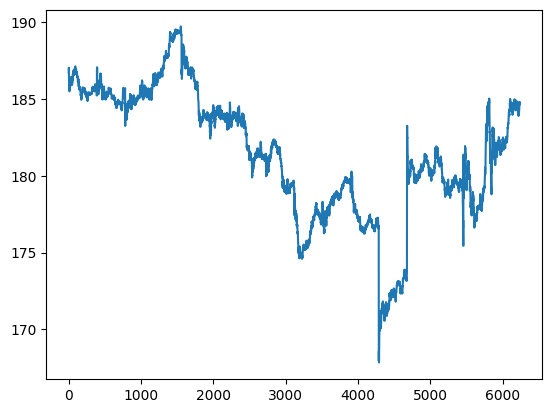

In [222]:
# As we are interested in predicting the closing price using the closing price only
# extracting the same from the dataset 
# Idea is to find patterns on the previous price change behaviour and predict the next closing accordingly
amazon_dataframe = amazon_data.reset_index()['Close']
plt.plot(amazon_dataframe)

In [223]:
# Data Normalization
scaler = MinMaxScaler(feature_range=(0,100))
amazon_dataframe = scaler.fit_transform(np.array(amazon_dataframe).reshape(-1,1))
amazon_dataframe.shape

(6236, 1)

In [224]:
train_data = amazon_dataframe[0:4000]
valid_data = amazon_dataframe[4000:5000]
test_data = amazon_dataframe[5000:]
print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(4000, 1)
(1000, 1)
(1236, 1)


Splitting the timeseries dataset

<img src="1.png" width="90%"/>

In [225]:
def create_time_series_dataset(data, time_step = 1):
    X_data = []
    Y_data = []
    for i in range(time_step, len(data)):
        X_data.append(data[i-time_step:i, 0])
        Y_data.append(data[i, 0])
    return np.array(X_data),np.array(Y_data)

In [226]:
time_step = 120
X_train, Y_train =  create_time_series_dataset(train_data, time_step)
X_valid, Y_valid =  create_time_series_dataset(valid_data, time_step)
X_test, Y_test =  create_time_series_dataset(test_data, time_step)

<h5>LSTM</h5>

An LSTM (Long Short-Term Memory) network is a type of RNN recurrent neural network that is capable of handling and processing sequential data. The structure of an LSTM network consists of a series of LSTM cells, each of which has a set of gates (input, output, and forget gates) that control the flow of information into and out of the cell. The gates are used to selectively forget or retain information from the previous time steps, allowing the LSTM to maintain long-term dependencies in the input data.

<h5>Structure of LSTM</h5>

<img src="2.png" width="90%"/>

<h5>Types of Gates in LSTM</h5>
There are three types of gates in an LSTM: the input gate, the forget gate, and the output gate. 

The input gate controls the flow of information into the memory cell. 
The forget gate controls the flow of information out of the memory cell. 
The output gate controls the flow of information out of the LSTM and into the output.

The input gate decides which information to store in the memory cell. It is trained to open when the input is important and close when it is not.

The forget gate decides which information to discard from the memory cell. It is trained to open when the information is no longer important and close when it is. 

The output gate is responsible for deciding which information to use for the output of the LSTM. It is trained to open when the information is important and close when it is not.

The gates in an LSTM are trained to open and close based on the input and the previous hidden state. This allows the LSTM to selectively retain or discard information, making it more effective at capturing long-term dependencies.

<h5>Model Configuration:</h5>
We employ an LSTM network with three layers, each containing 64 units. The model is compiled with mean squared error as the loss function and uses the Adam optimizer.
Training is performed over 100 epochs with a batch size of 128.

In [227]:
model = Sequential()
model.add(LSTM(64,return_sequences = True, input_shape = (X_train.shape[1],1)))
model.add(LSTM(64,return_sequences = True))
model.add(LSTM(64))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')
History = model.fit(X_train, Y_train, validation_data = (X_valid, Y_valid),epochs = 100, batch_size = 128)

Epoch 1/100


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - loss: 4314.1724 - val_loss: 918.6010
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 3243.3145 - val_loss: 713.6470
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - loss: 2796.4402 - val_loss: 569.1323
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - loss: 2396.9709 - val_loss: 462.3751
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - loss: 2113.0862 - val_loss: 387.1803
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 1827.0222 - val_loss: 338.6992
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - loss: 1576.4900 - val_loss: 313.2650
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - loss: 1328.3953 - val_loss: 307.5144
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - loss: 1163.7256 - val_loss: 318.5520
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - loss: 972.4428 - val_loss: 343.3436
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - loss: 869.6483 - val_loss: 379.8898


In [305]:
model_2 = Sequential()
model_2.add(Dense(64, input_shape=(X_train.shape[1],1), activation="relu"))
model_2.add(Flatten()) 
model_2.add(Dense(64, activation="relu"))
model_2.add(Dense(64, activation="relu"))
model_2.add(Dense(1))
model_2.compile(loss = 'mean_squared_error',optimizer = 'adam')
History_2 = model_2.fit(X_train, Y_train, validation_data = (X_valid, Y_valid),epochs = 100, batch_size = 128)

Epoch 1/100


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 483.6887 - val_loss: 84.3981
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.2875 - val_loss: 69.3798
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7778 - val_loss: 55.9875
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.0349 - val_loss: 46.6139
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9956 - val_loss: 39.5090
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3584 - val_loss: 35.4089
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9901 - val_loss: 32.5079
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7793 - val_loss: 30.4308
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5253 - val_loss: 29.5224
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8091 - val_loss: 28.1530
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4389 - val_loss: 26.3059
Epoch 12/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3

In [306]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict_2 = model_2.predict(X_train)
test_predict_2 = model_2.predict(X_test)

122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


In [307]:
test_predict = scaler.inverse_transform(test_predict)
test_predict_2 = scaler.inverse_transform(test_predict_2)

real_data = scaler.inverse_transform(np.array(Y_test).reshape(-1,1))

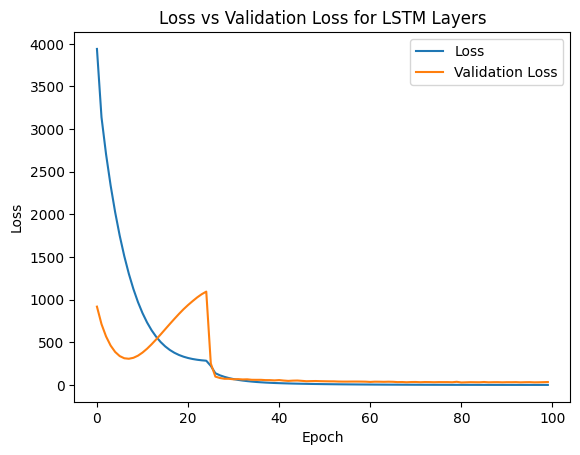

In [308]:
plt.plot(History.history['loss'], label='Loss')
plt.plot(History.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Validation Loss for LSTM Layers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

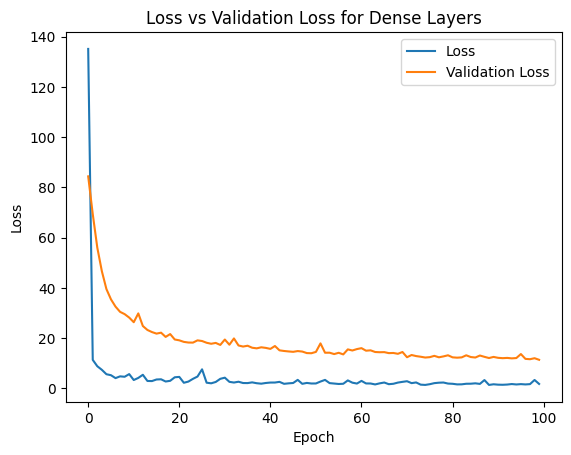

In [309]:
plt.plot(History_2.history['loss'], label='Loss')
plt.plot(History_2.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Validation Loss for Dense Layers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

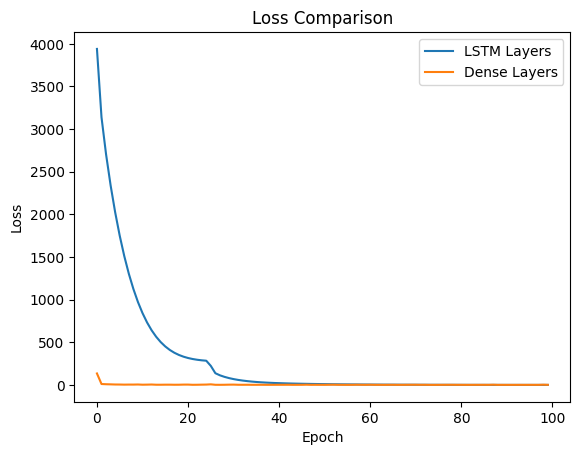

In [310]:
plt.plot(History.history['loss'], label='LSTM Layers')
plt.plot(History_2.history['loss'], label='Dense Layers')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

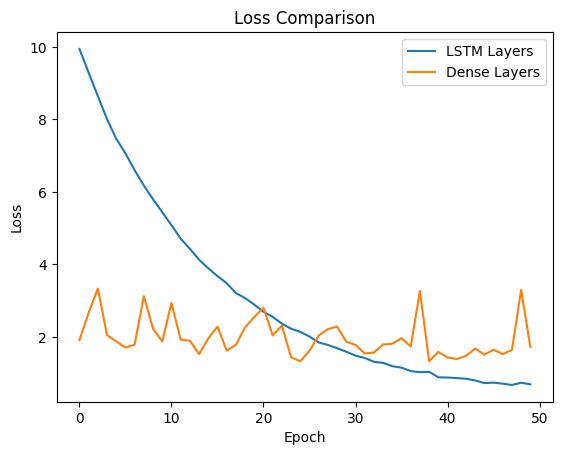

In [311]:
plt.plot(History.history['loss'][50:], label='LSTM Layers')
plt.plot(History_2.history['loss'][50:], label='Dense Layers')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

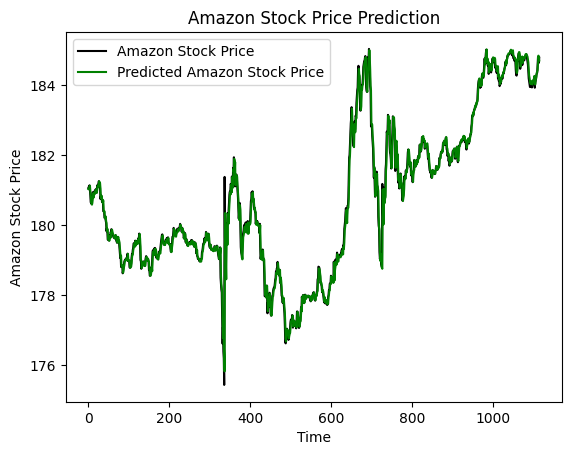

In [312]:
plt.plot(real_data, color = 'black', label = 'Amazon Stock Price')
plt.plot(test_predict, color = 'green', label = 'Predicted Amazon Stock Price')
plt.title('Amazon Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Amazon Stock Price')
plt.legend()
plt.show()

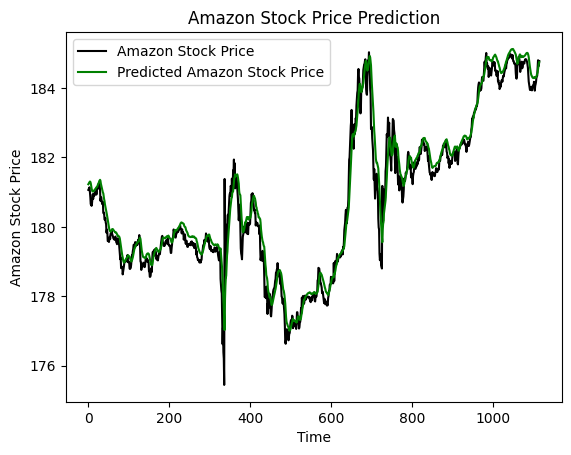

In [313]:
plt.plot(real_data, color = 'black', label = 'Amazon Stock Price')
plt.plot(test_predict_2, color = 'green', label = 'Predicted Amazon Stock Price')
plt.title('Amazon Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Amazon Stock Price')
plt.legend()
plt.show()

In [314]:
predicted_reshaped_array = test_predict.reshape(len(test_predict))
real_reshaped_array = real_data.reshape(len(real_data))

df = pd.DataFrame()
df['real'] = real_reshaped_array
df['predict'] = predicted_reshaped_array
df['real_pct_change'] = df['real'].pct_change()
df['predict_pct_change'] = df['predict'].pct_change()
df.head(5)

,real,predict,real_pct_change,predict_pct_change
0,181.065002,181.032990,NaN,NaN
1,181.089996,181.046051,0.000138,0.000072
2,181.119995,181.068176,0.000166,0.000122
3,181.139999,181.106796,0.000110,0.000213
4,181.000000,181.127792,-0.000773,0.000116


In [315]:
correct = 0
gain = 0
for i in range(1, len(real_reshaped_array)):
    if ((df['real_pct_change'][i] > 0 and df['predict_pct_change'][i] > 0) or 
        df['real_pct_change'][i] < 0 and df['predict_pct_change'][i] < 0):
        correct = correct + 1
        gain += abs(df['real_pct_change'][i])
    else: 
        gain -= abs(df['real_pct_change'][i])
print(gain)
print(correct)
print(correct/(len(real_reshaped_array)-1))

0.026011760722478572
593
0.5318385650224215


In [316]:
predicted_reshaped_array = test_predict_2.reshape(len(test_predict_2))

df = pd.DataFrame()
df['real'] = real_reshaped_array
df['predict'] = predicted_reshaped_array
df['real_pct_change'] = df['real'].pct_change()
df['predict_pct_change'] = df['predict'].pct_change()

Let's compute the gains and accuracy of our predictions to determine the actual effectiveness of the model. For example, if the model predicted a 1% increase, did that actually occur? This will help us assess the accuracy of the model's predictions.

In [317]:
correct = 0
gain = 0
for i in range(1, len(real_reshaped_array)):
    if ((df['real_pct_change'][i] > 0 and df['predict_pct_change'][i] > 0) or 
        df['real_pct_change'][i] < 0 and df['predict_pct_change'][i] < 0):
        correct = correct + 1
        gain += abs(df['real_pct_change'][i])
    else: 
        gain -= abs(df['real_pct_change'][i])
print(gain)
print(correct)
print(len(real_reshaped_array))
print(correct/(len(real_reshaped_array)-1))

0.09465265523385491
608
1116
0.5452914798206278


**Prediction of Random Numbers**

In [368]:
import random
numbers = []
for i in range(1,10000):
    numbers.append(random.randint(0, 36))

In [369]:
numbers_dataframe = pd.DataFrame()
numbers_dataframe['Numbers'] = numbers

train_data_2 = numbers_dataframe[0:6000]
train_data_2 = np.array(train_data_2).reshape(-1,1)

valid_data_2 = numbers_dataframe[6000:8000]
valid_data_2 = np.array(valid_data_2).reshape(-1,1)

test_data_2 = numbers_dataframe[8000:]
test_data_2 = np.array(test_data_2).reshape(-1,1)

In [370]:
time_step = 100
X_train_2, Y_train_2 =  create_time_series_dataset(train_data_2,time_step)
X_test_2, Y_test_2 =  create_time_series_dataset(test_data_2,time_step)
X_valid_2, Y_valid_2 =  create_time_series_dataset(valid_data_2,time_step)

In [371]:
model_3 = Sequential()
model_3.add(LSTM(64,return_sequences = True,input_shape = (X_train_2.shape[1],1)))
model_3.add(LSTM(64,return_sequences = True))
model_3.add(LSTM(64))
model_3.add(Dense(1))
model_3.compile(loss = 'mean_squared_error',optimizer = 'adam')
History_3 = model_3.fit(X_train_2,Y_train_2,validation_data = (X_valid_2,Y_valid_2),epochs = 50,batch_size = 128)

Epoch 1/50


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - loss: 311.9933 - val_loss: 144.5487
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - loss: 140.1528 - val_loss: 123.2290
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - loss: 123.3133 - val_loss: 116.8330
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - loss: 117.8199 - val_loss: 115.5690
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - loss: 116.9639 - val_loss: 115.4597
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - loss: 117.1657 - val_loss: 115.4795
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - loss: 115.8451 - val_loss: 115.4960
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - loss: 115.0642 - val_loss: 115.4852
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 117.2274 - val_loss: 115.5404
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 112.8173 - val_loss: 115.5021
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - loss: 115.8418 - val_loss: 115.5208
Epoch 12/50
47/47 ━

In [372]:
model_4 = Sequential()
model_4.add(Dense(64, input_shape=(X_train_2.shape[1],1), activation="relu"))
model_4.add(Flatten()) 
model_4.add(Dense(64, activation="relu"))
model_4.add(Dense(64, activation="relu"))
model_4.add(Dense(1))
model_4.compile(loss = 'mean_squared_error',optimizer = 'adam')
History_4 = model_4.fit(X_train_2, Y_train_2, validation_data = (X_valid_2, Y_valid_2),epochs = 50, batch_size = 128)

Epoch 1/50


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 145.0817 - val_loss: 118.6390
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 119.3293 - val_loss: 122.6035
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 119.9667 - val_loss: 122.9500
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 117.8502 - val_loss: 123.7151
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 114.6001 - val_loss: 119.7501
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 115.1743 - val_loss: 119.4941
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 117.1746 - val_loss: 124.2399
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 122.2935 - val_loss: 121.5191
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 114.3936 - val_loss: 119.6913
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 115.4370 - val_loss: 119.8643
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 115.4195 - val_loss: 120.1336
Epoch 12/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 

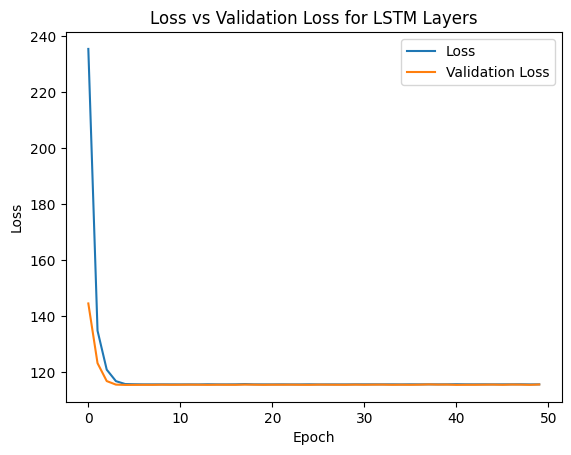

In [373]:
plt.plot(History_3.history['loss'], label='Loss')
plt.plot(History_3.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Validation Loss for LSTM Layers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

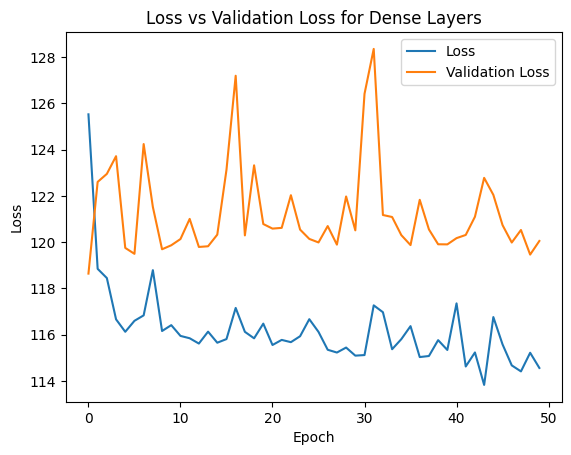

In [374]:
plt.plot(History_4.history['loss'], label='Loss')
plt.plot(History_4.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Validation Loss for Dense Layers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [375]:
predict_3 = model_3.predict(X_test_2)
predict_4 = model_4.predict(X_test_2)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step


In [376]:
predict_3 = predict_3.reshape(len(predict_3))
predict_4 = predict_4.reshape(len(predict_4))
Y_test_2 = Y_test_2.reshape(len(Y_test_2))

In [377]:
predict_3 = predict_3.astype(int)
predict_4 = predict_4.astype(int)

In [378]:
print(len(predict_3))
count = 0
for i in range(0,len(predict_3)-1):
    if predict_3[i] == Y_test_2[i]:
        count += 1
print(count)
print(count/len(predict_3))

1899
61
0.032122169562927856


In [379]:
print(len(predict_4))
count = 0
for i in range(0,len(predict_4)-1):
    if predict_4[i] == Y_test_2[i]:
        count += 1
print(count)
print(count/len(predict_4))

1899
59
0.031068983675618746


<h5>Conclusion:</h5>
The LSTM model showed promising results in predicting Amazon stock prices, capturing trends effectively despite the market's volatility. 
However, the model's performance on the random integers dataset was limited. 
This outcome highlights LSTM's strengths in scenarios with underlying patterns but suggests limitations in random or highly volatile contexts.

<h5>Future Work:</h5>

Exploring more complex LSTM architectures or hybrid models.
Incorporating additional features such as volume and open price for stock predictions.
Testing the models on a wider range of time series data.
For predicting random integers we can try adding more layers or more nodes/ neurons per layer to the model and use 37 classes for each number on the output layer and try with softmax activation.</br>

The idea behind predicting the random integer between 0 to 36 is to use such a model in a game of Roulette.
We are currently employing Python's random function, which is designed to avoid predictable patterns, making it challenging to predict. Nevertheless, our model has performed slightly better than the expected probability of 1/37. </br>I believe that using real-world data would further enhance the model's accuracy.

### References for LSTM Networks in Stock Prediction

1. **Derrick Mwiti (2018).** "Data and Notebook for the Stock Price Prediction Tutorial," GitHub.  
   *This tutorial provides a practical implementation of LSTM networks for stock price prediction, including accessible data and a Jupyter notebook on GitHub.*

2. **Nelson, D. M., Pereira, A. C. M., & de Oliveira, R. A. (2017).** "Stock market's price movement prediction with LSTM neural networks."  
   *This reference discusses the application of LSTM neural networks to predict movements in stock market prices, highlighting the effectiveness of LSTM models in capturing long-term temporal dependencies in financial time series data.*